## EKSPERYMENT 1
### Komputer.

Część 1: Przygotowanie danych i trenowanie klasyfikatorów

Część 2: Dane, metoda

Część 3: Badanie jakości w strumieniu o zmiennej strudności

## Część 1: Trenowanie

In [10]:
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Prepare trainig data
train_data = torchvision.datasets.SVHN('./files/', 
                                  split='test', #Tak.
                                  download=True)

train_X = (torch.tensor(train_data.data)/255).to(torch.float)
train_y = train_data.labels

dataset = TensorDataset(torch.Tensor(train_X),torch.Tensor(train_y))
dataloader = DataLoader(dataset, batch_size=64)

print(train_X.shape)
print(train_y.shape)

Using downloaded and verified file: ./files/test_32x32.mat
torch.Size([26032, 3, 32, 32])
(26032,)


In [11]:
from architectures import CNN, CNN1_10_Network, CNN1_5_Network, CNN2_10_20_Network, CNN2_5_10_Network, CNN3_5_10_20_Network, FC_Network

# Initialize and train classifiers
max_training_epochs = 250
training_support_level = 0.8

clfs = [
    CNN(architecure=FC_Network(img_depth=3, x_input_size=32)),
    CNN(architecure=CNN1_5_Network(img_depth=3, x_input_size=32)),
    CNN(architecure=CNN1_10_Network(img_depth=3, x_input_size=32)),
    CNN(architecure=CNN2_5_10_Network(img_depth=3, x_input_size=32)),
    CNN(architecure=CNN2_10_20_Network(img_depth=3, x_input_size=32)),
    CNN(architecure=CNN3_5_10_20_Network(img_depth=3, x_input_size=32)),  
]

loss_fn = torch.nn.CrossEntropyLoss()

for clf_id, clf in enumerate(clfs):
    optimizer = torch.optim.SGD(clf.parameters(), lr=1e-2)

    for e in range(max_training_epochs):
        if e==0:
            clf.train(dataloader, loss_fn, optimizer)
        else:

            proba = nn.Softmax(dim=1)( clf(train_X))
            max_proba = torch.max(proba, dim=1)[0] 
            mean_proba = torch.mean(max_proba).detach().numpy() # średnie wsparcie decyzyjne

            if mean_proba>training_support_level:
                print(clf_id, e, mean_proba)
                break
            
            clf.train(dataloader, loss_fn, optimizer)
        
        if e%50==1:
            print(clf_id, e, mean_proba)
            

0 1 0.18599333
0 51 0.74674827
0 73 0.8031468
1 1 0.18966399
1 51 0.7343835
1 101 0.78045094
1 151 0.79133505
1 201 0.79741496
1 230 0.8000609
2 1 0.1945208
2 50 0.80065465
3 1 0.18893427
3 21 0.80185467
4 1 0.18803671
4 23 0.801934
5 1 0.18952617
5 32 0.80242145


In [17]:
# Save classifers
for c_id, c in enumerate(clfs):
    torch.save(c, 'models/%i.pt' % c_id)

## Część 2: Przygotowanie danych i CDoS

In [18]:
import numpy as np
from sklearn.decomposition import PCA
from ConditionalEvidenceStream import ConditionalEvidenceStream
from utils import make_condition_map, mix_to_factor
import concepts
import torch
import torchvision

# Load data
stream_data = torchvision.datasets.SVHN('./files/', 
                                  split='train', 
                                  download=True)

X = torch.tensor(stream_data.data)/255
y = stream_data.labels

X_pca = PCA(n_components=0.8).fit_transform(X.reshape(X.shape[0],-1))
X_pca -= np.mean(X_pca, axis=0)
X_pca /= np.std(X_pca, axis=0)

factor = mix_to_factor(X_pca)

Using downloaded and verified file: ./files/train_32x32.mat


In [20]:
# Load models

clfs=[]
for c_id in range(6):
    clfs.append(torch.load('models/%i.pt' % c_id))

In [21]:
from Method import CDoS_T

# Prepare method
thresholds = [1., 0.95, 0.9, 0.85, 0.8, 0.75]
cdos = CDoS_T(clfs=clfs,
           thresholds=thresholds)


## Część 3: Eksperyment

In [31]:

import time
from sklearn.metrics import accuracy_score

# Experimental setup
n_chunks = 1000
chunk_size = [25, 250, 500]
n_cycles = [5, 10, 25]
modes = {
    'instant': {'mode': 'instant'},
    'normal_1': {'mode': 'normal', 'sigma': 1},
    'normal_3': {'mode': 'normal', 'sigma': 3}
    }

accs = np.zeros((len(chunk_size), len(n_cycles), len(modes), n_chunks, 7))
times = np.zeros((len(chunk_size), len(n_cycles), len(modes), n_chunks, 7))
cdos_selected = np.zeros((len(chunk_size), len(n_cycles), len(modes), n_chunks))

for cs_id, cs in enumerate(chunk_size):
    for n_c_id, nc in enumerate(n_cycles):
        for m_id, mode in enumerate(modes):

            condition_map = make_condition_map(n_cycles=nc,
                                            n_concepts=500,
                                            factor=factor,
                                            factor_range=(0.1,0.9))

            cp = concepts.concept_proba(n_concepts=500,
                                        n_chunks=n_chunks,
                                        normalize=True,
                                        **modes[mode])

            stream = ConditionalEvidenceStream(X, y,
                                            condition_map.T,
                                            cp,
                                            chunk_size=cs,
                                            fragile=False)
            
            

            
            for chunk_id in range(n_chunks):
                _X, _y = stream.get_chunk()
                
                # Regular clfs
                for c_id, c in enumerate(clfs):
                    start = time.time()
                    proba = nn.Softmax(dim=1)(c(_X))
                    p = torch.argmax(proba, dim=1)    
                    elapsed = time.time()-start
                    
                    accs[cs_id, n_c_id, m_id, chunk_id, c_id] = accuracy_score(_y, p)
                    times[cs_id, n_c_id, m_id, chunk_id, c_id] = elapsed
                    
                #CDos
                start = time.time()
                p = cdos.predict(_X)
                elapsed = time.time()-start
                
                accs[cs_id, n_c_id, m_id, chunk_id, -1] = accuracy_score(_y, p)
                times[cs_id, n_c_id, m_id, chunk_id, -1] = elapsed
                
                cdos_selected[cs_id, n_c_id, m_id, chunk_id] = cdos.curr_clf_id
                
            # print(accs[cs_id, n_c_id, m_id, chunk_id])
            # print(times[cs_id, n_c_id, m_id, chunk_id])
            print(np.unique(cdos_selected[cs_id, n_c_id, m_id], return_counts=True))
            
            np.save('e1_accs.npy', accs)
            np.save('e1_times.npy', times)
            np.save('e1_selected.npy', cdos_selected)
            
            


/Users/joana/Documents/projects/stream-difficulty/concepts.py:50: RuntimeWarning: invalid value encountered in divide
  concept_proba = concept_proba / np.sum(concept_proba, axis=1)[:,None]


[5. 5. 5. 5. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 4. 4.

KeyboardInterrupt: 

## Analiza wyników

In [25]:
accs = np.load('e1_accs.npy')
times = np.load('e1_times.npy')

print(accs.shape, times.shape)

#cs_id, n_c_id, m_id, chunk_id, c_id

(3, 3, 3, 1000, 7) (3, 3, 3, 1000, 7)


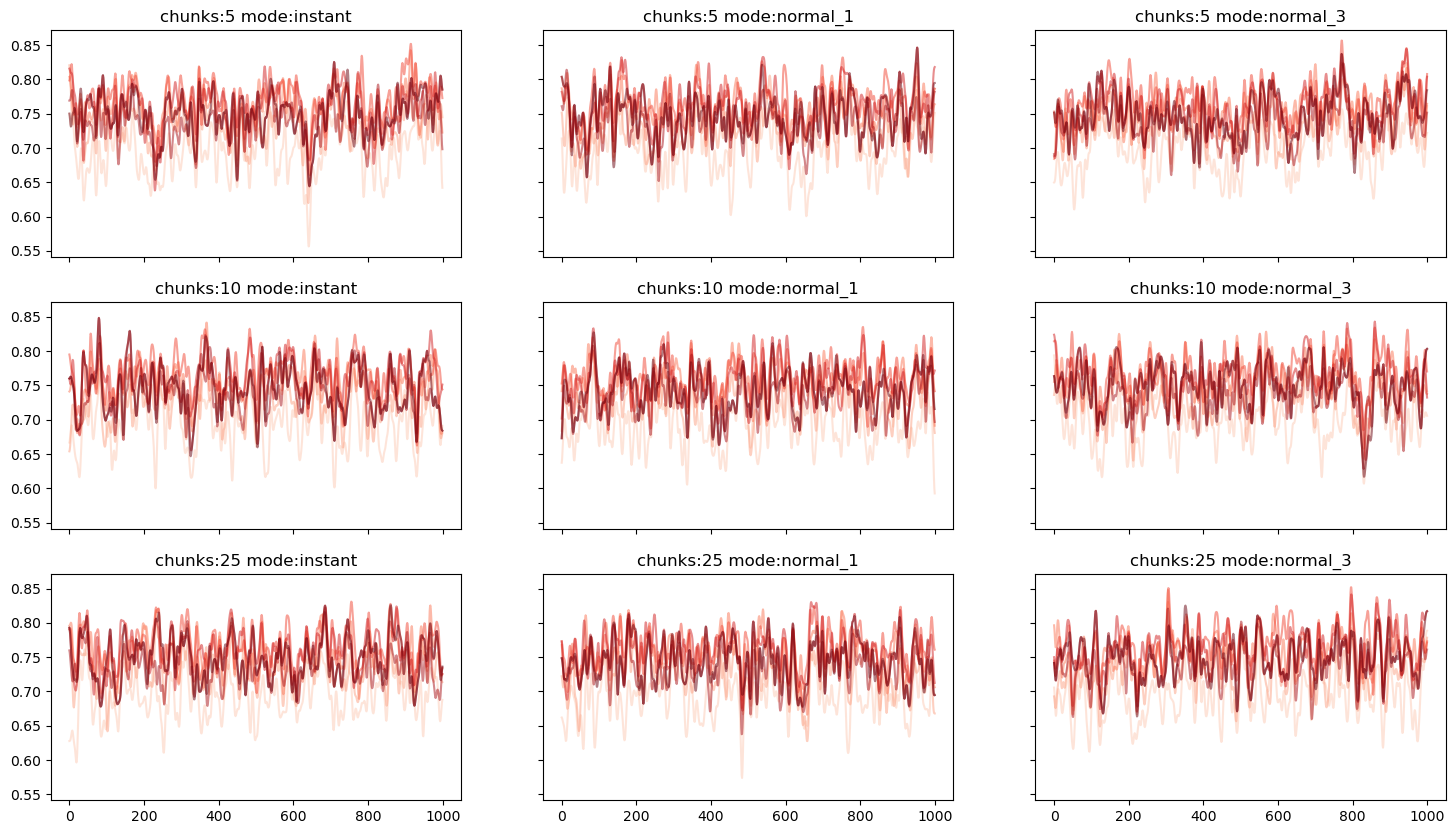

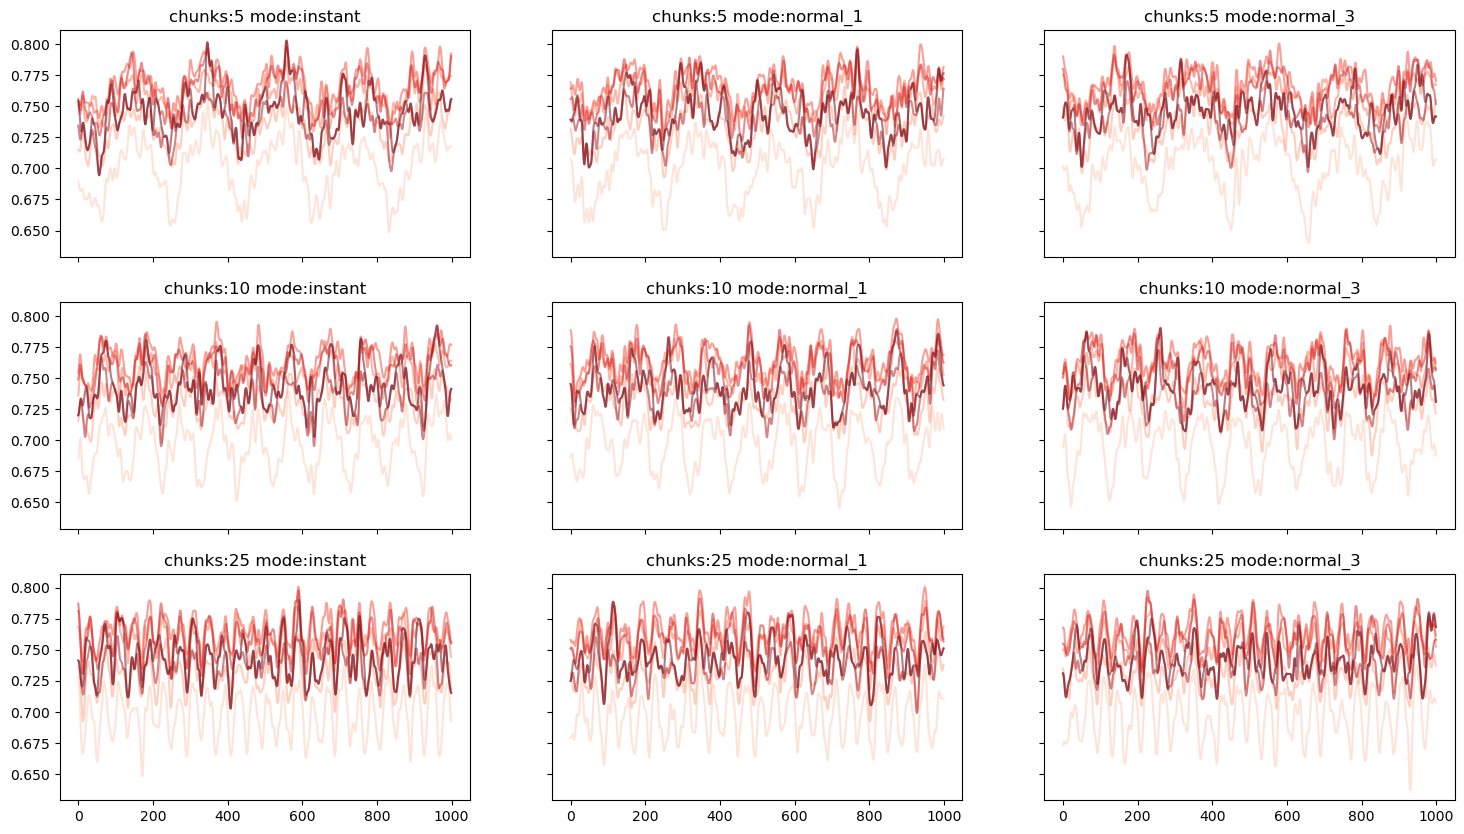

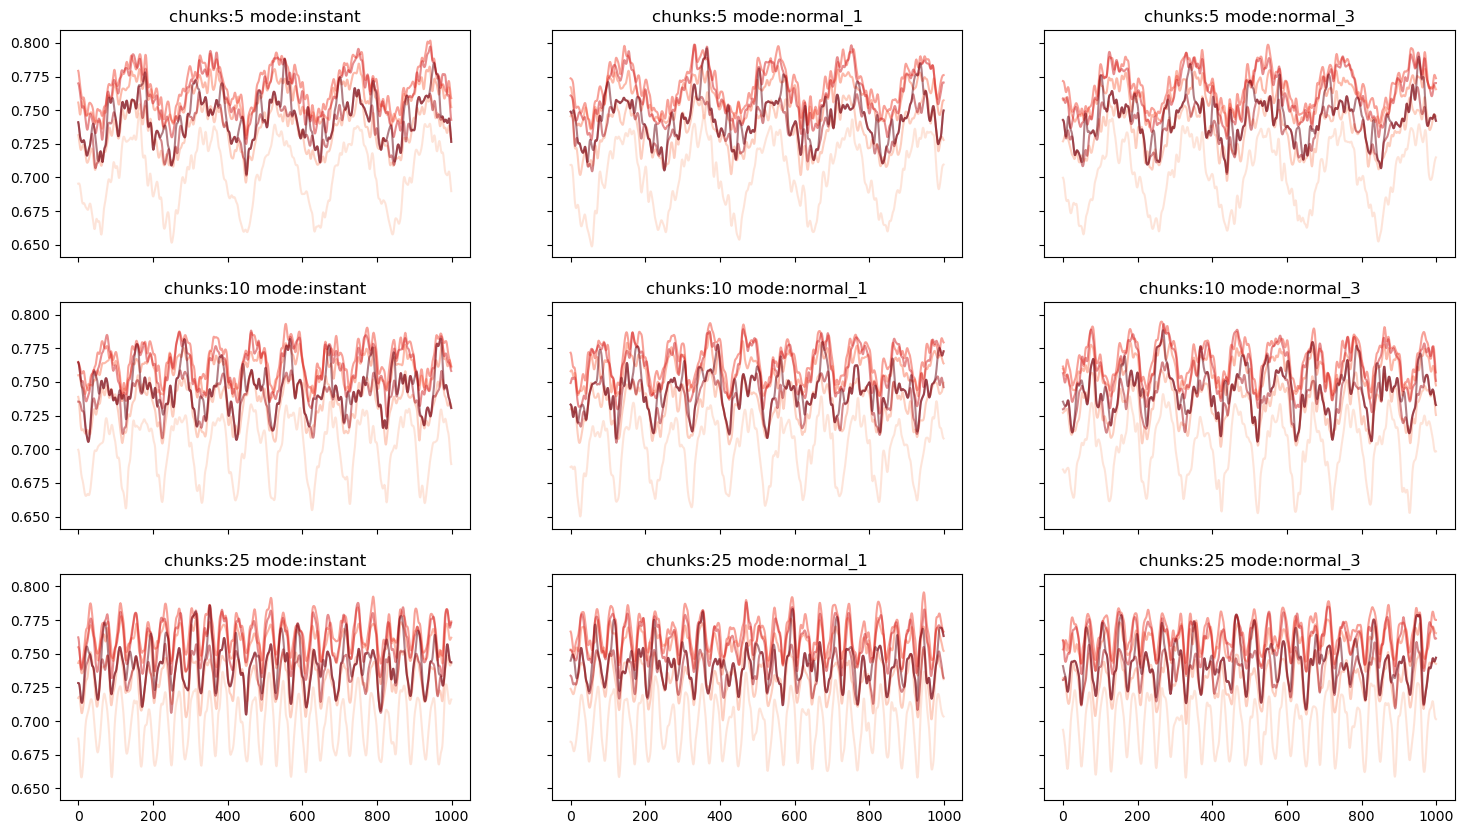

In [29]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

s=3
cols = plt.cm.Reds(np.linspace(0.2,1,7))

for c_id, c in enumerate(chunk_size):
    fig, ax = plt.subplots(3,3, figsize=(18,10), sharex=True, sharey=True)
    
    for n_c_id, n_c in enumerate(n_cycles):
        for mode_id, mode in enumerate(modes):
            
            ax[n_c_id, mode_id].set_title('cycles:%i mode:%s' % (n_c, mode))
            for method_id in range(7):
                temp = accs[c_id, n_c_id, mode_id, :, method_id]
                ax[n_c_id, mode_id].plot(gaussian_filter1d(temp, s), c=cols[method_id], alpha=0.5)
    
    plt.show()
    
                

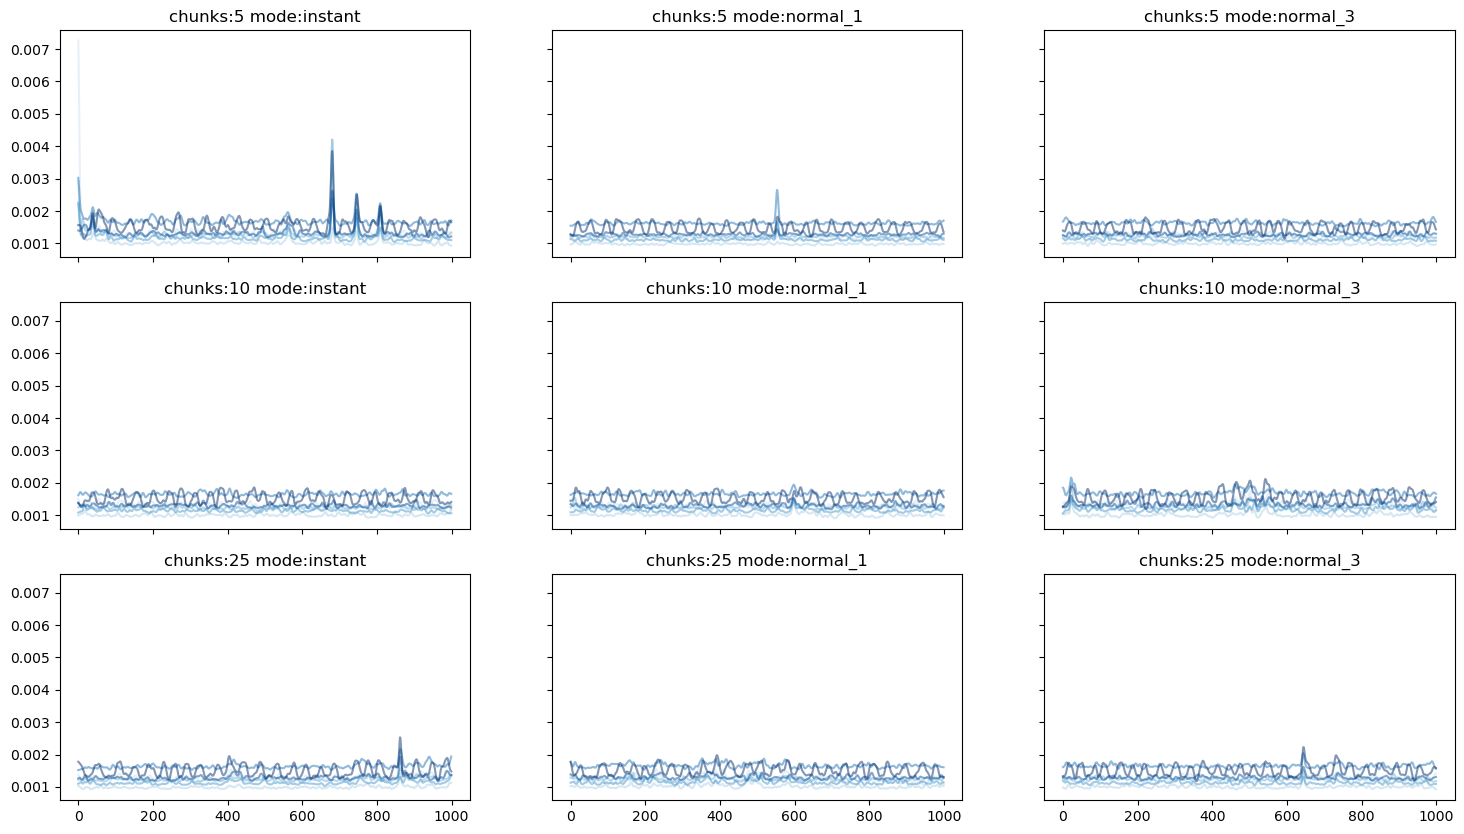

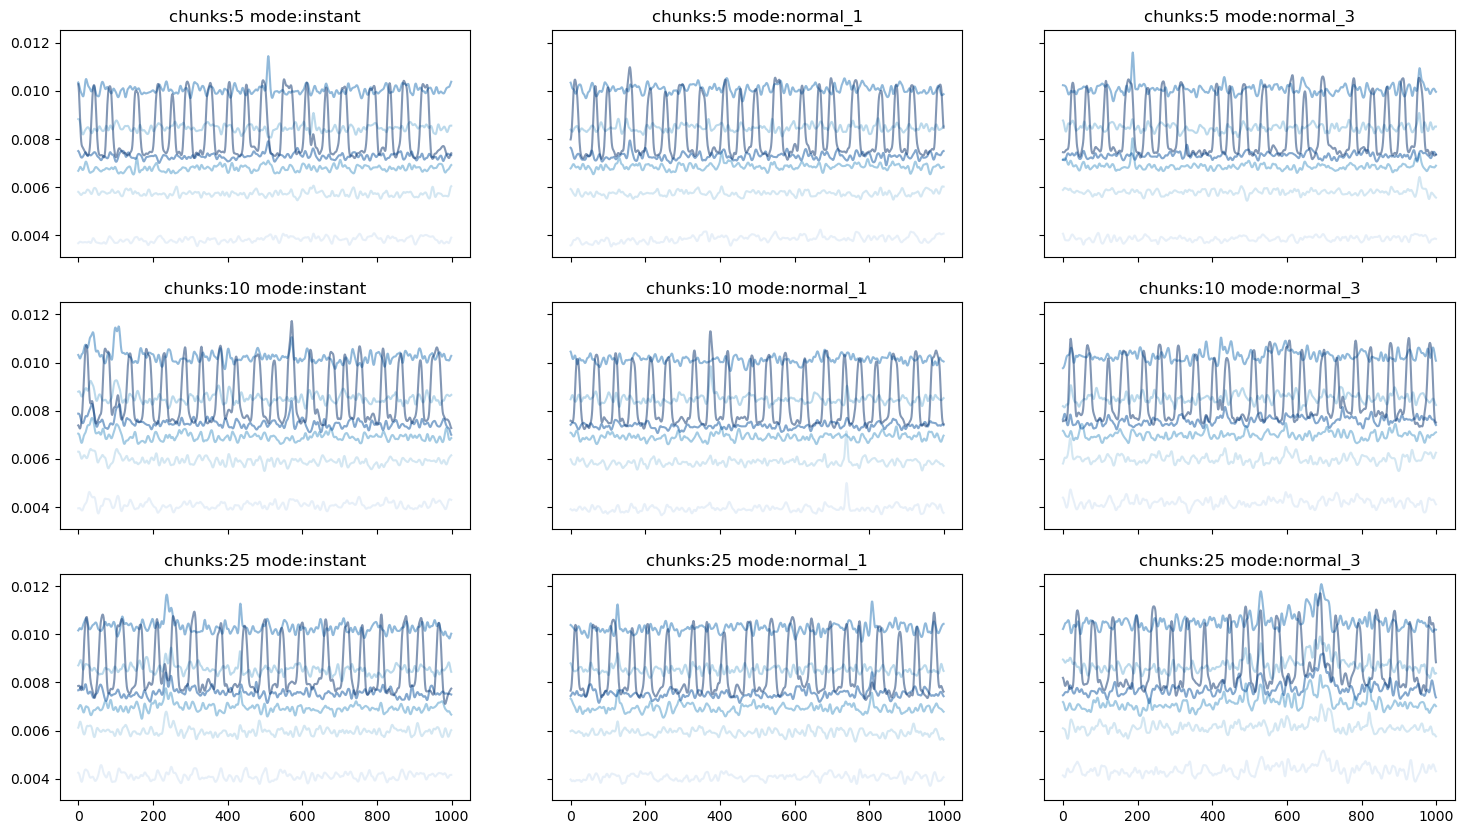

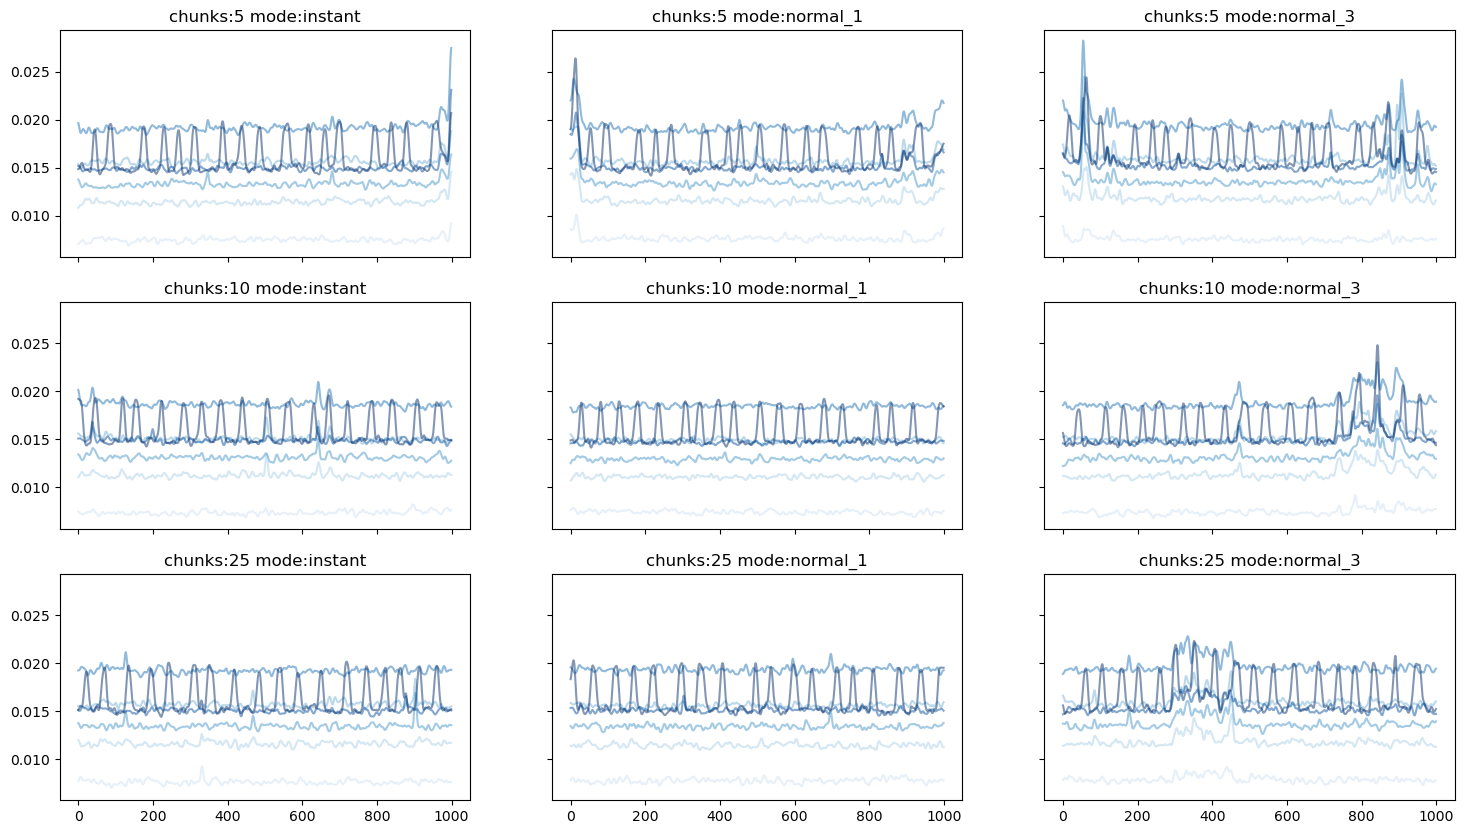

In [30]:
cols = plt.cm.Blues(np.linspace(0.2,1,7))

for c_id, c in enumerate(chunk_size):
    fig, ax = plt.subplots(3,3, figsize=(18,10), sharex=True, sharey=True)
    
    for n_c_id, n_c in enumerate(n_cycles):
        for mode_id, mode in enumerate(modes):
            
            ax[n_c_id, mode_id].set_title('chunks:%i mode:%s' % (n_c, mode))
            for method_id in range(7):
                temp = times[c_id, n_c_id, mode_id, :, method_id]
                ax[n_c_id, mode_id].plot(gaussian_filter1d(temp, s), c=cols[method_id], alpha=0.5)
    
    plt.show()